In [ ]:
# MIT License

# Copyright (c) 2022 Alexandru Pascu and Stefano Li Pira

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

**Measuring the Stereotype of IMDB movies and series using a BERT NLP model Version: 1.0 Date: 2022-10-7**

> This notebook contains complete code to fine-tune the transformers language model BERT to perform categorization of movies and series into a label especially the probability of them being a Stereotype title. We will use BERT to categorize titles from IMDB datasets in stereotypes and non-stereotypes (the categories can be easily changed for other usecases). Data needed for this matter is the users keywords of titles and plots (we are excluding game-show, talk-show, reality-tv and filtering for drama and comedy. We are including only episodes with at least 1 rating for relevance). BigQuery has been used for some data cleaning purposes.

**In this notebook, you will:**

> Download and load a dataset of series title episodes with various information about them such as actors, production, ratings, plots, keywords and others. Based on the users existing keywords titles will be put into a category (easily changeble) and used for training and then labeling others (keywords can be changed and use in different ways). The dataset was created from the Goodreads dataset. Load a BERT model from the Transformers Library, build your own model by combining BERT with a classifier. Train your own model on a GPU, fine-tuning BERT on the training dataset. Use the trained model to classify titles as Stereotype using plots. Use the predicted categorization probabilities to run regressions and find insights. You can use this notebook on your own data from other domains and categories, by ensuring that your input and prediction datasets have the same structure and column names as those provided with this notebook. Alternatively the later can be modified as well to suit your use-case.

**File Paths**

Mount your drive folder in the colab.

The folllowing cell should be modified if you are using different input/prediction files or if you have changed the folder name.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install and load libraries**

In [ ]:
# install the Cinemagoer API
!pip install cinemagoer
# install the Simple Transformers library
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# General Packages #
import os
import pandas as pd
import numpy as np

# CSV handling library
import csv

# Cinemagoer library
from imdb import Cinemagoer, IMDbError

# The classification Model used to label data
from simpletransformers.classification import ClassificationModel

# TQDM to Show Progress Bars #
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

# SKLearn libraries for splitting sample and validation
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

# Matplot and SkLearn libraries for doing regressions
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Additional Libraries that we are using only in this notebook
import torch
import gc

**Cinemagoer API**

The following code blocks are to help with understanding better what data Cinemagoer (https://cinemagoer.github.io/) is capable of retrivieving from IMDB (https://www.imdb.com/). We also provide access to how we handled our data collection process.

In [ ]:
# create an instance of the Cinemagoer class
ia = Cinemagoer()

# get a movie and print its director(s)
the_matrix = ia.get_movie('0720229')
for director in the_matrix['directors']:
  print(director['name'])

# show all information that are currently available for a movie
print(sorted(the_matrix.keys()))

# show all information sets that can be fetched for a movie
print(ia.get_movie_infoset())

# update a Movie object with more information
ia.update(the_matrix, ['technical'])

# show which keys were added by the information set
print(the_matrix.infoset2keys['technical'])

# print one of the new keys
print(the_matrix.get('tech'))

# print different information
print(the_matrix.get('plot'))
print(the_matrix.get('plot outline'))
print(the_matrix.get('synopsis'))
print(the_matrix.get('keywords'))
print(the_matrix.get('title'))
print(the_matrix.get('production companies'))

In the following blocks you can use the code to get data neede for the title codes you want. We were interested in plots, keywords, production companies, and countries. 

In [ ]:
# initialize the header row 
headers = ['production companies', 'plot', 'plot outline', 'synopsis',
           'keywords', 'countries', 'title_code']
# initialize data
data = ['', '', '', '', '', '', '']

# add the csv file with the title codes to get data on, in colab files on left
file = open("title_codes.csv")
csvreader = csv.reader(file)
header = next(csvreader)
rows = []
# add all the codes in the rows variable
for row in csvreader:
  rows.append(row)
file.close()

# creata a folder to store the data from imdb
f = open('titles_data.csv', 'w', encoding='UTF8', newline='')
writer = csv.writer(f)
writer.writerow(headers)

# iterate through all the the titles codes and getting data interested in
for x in rows:
  try:
    x_string = ' '.join(map(str, x))
    the_matrix = ia.get_movie(x_string)
    if the_matrix.get('production companies') is None:
      data[0] = "NULL"
    else:
      data[0] = the_matrix.get('production companies')
    if the_matrix.get('plot') is None:
      data[1] = "NULL"
    else:
      data[1] = the_matrix.get('plot')[0]
    if the_matrix.get('plot outline') is None:
      data[2] = "NULL"
    else:
      data[2] = the_matrix.get('plot outline')
    if the_matrix.get('synopsis') is None:
      data[3] = "NULL"
    else:
      data[3] = the_matrix.get('synopsis')
    # keywords weren't adding correctly; see below the solution for getting them
    if the_matrix.get('keywords') is None:
      data[4] = "NULL"
    else:
      data[4] = the_matrix.get('keywords')
    if the_matrix.get('countries') is None:
      data[5] = "NULL"
    else:
      data[5] = the_matrix.get('countries')
    data[6] = "tt" + x_string
    writer.writerow(data)
  except IMDbError as e:
    print(e)
    continue

f.close()

We discovered a problem in the implementation of the API hence we used the following code to get the keyowrds of the title as well. They require a special approach.

In [ ]:
# initialize the header row 
headers = ['title_codes', 'keywords_title']
# initialize data
data = ['', '']

# add the csv file with the title codes to get data on, in colab files on left
file = open("title_codes.csv")
csvreader = csv.reader(file)
rows = []
# add all the codes in the rows variable
for row in csvreader:
  rows.append(row)
file.close()

# creata a folder to store the data from imdb
f = open('titles_keywords.csv', 'w', encoding='UTF8', newline='')
writer = csv.writer(f)
writer.writerow(headers)

# get all the keywords of the titles
for x in rows:
  x_string = ' '.join(map(str, x))
  data[0] = "tt" + x_string
  try:
    title = ia.get_movie(x_string, info='keywords')
    try:
      data[1] = title['keywords']
    except:
      data[1] = "NULL"
  except IMDbError as e:
    print(e)
    continue
  writer.writerow(data)
f.close

Below we wanted to have the opposite approach, we had a couple of specific keywords area that we were looking for similar ones in the imdb database. Afterwards we used them to get the title codes associated with all these keywords.

In [ ]:
# creata a folder to store the data from imdb
f = open('tiles_from_keywords.csv', 'w', encoding='UTF8', newline='')
writer = csv.writer(f)
data = ['', '']

# compute the list of 'categories' that you want to get similar keywords for
keywordsList = ['stereotype', 'sexism', 'homophobic',
                'racism', 'discrimination']
# iterate through your list and get similar keywords
for keywordIndividual in keywordsList:
  keywords = ia.search_keyword(keywordIndividual)
  print(keywords)
  # iterate through the list of similar keywords and get title codes for them
  for keywwordsSimilar in keywords:
    movies = ia.get_keyword(keywwordsSimilar)
    # save all the titles in a csv file
    for title in movies:
      data[0] = 'tt' + ''.join(title.movieID)
      data[1] = keywwordsSimilar
      writer.writerow(data)
f.close()

For using them to train the model as well, get their plots and all of the keywords they have for each title code found earlier.

In [ ]:
# initialize the header row 
headers = ['title_codes', 'keywords_title', 'plot']
# initialize data
data = ['', '', '']

# open the file containing the title codes and add them to a variable
file = open("tiles_from_keywords.csv")
csvreader = csv.reader(file)
rows = []
for row in csvreader:
  rows.append(row)
file.close()

# creata a folder to store the data from imdb
f = open('plots_and_keywords_extra_titles.csv', 'w',
         encoding='UTF8', newline='')
writer = csv.writer(f)
writer.writerow(headers)

# get all the keywords and plots of the titles
for x in rows:
  data[0] = ''.join(map(str, x))
  x_string = data[0][2:]
  try:
    title = ia.get_movie(x_string, info=['keywords', 'plot'])
    try:
      data[1] = title['keywords']
    except:
      data[1] = "NULL"
    try:
      data[2] = title['plot']
    except:
      data[2] = "NULL"
  except IMDbError as e:
    print(e)
    continue
  writer.writerow(data)
f.close

**Prepare data for the ML model**

From now on the focus starts to be on preparing the data for the ML model. Preparing the labels, the needed columns from our dataset (namely plots, keywords, title codes) and associating the Label Stereotype or not.

In [ ]:
# have a list of keywords that you want to find similars
labelList = ['stereotype', 'sexism', 'homophobic', 'racism', 'discrimination']
keywords = ([[], [], [], [], []])

# iterate through the keywords list to get the similar ones
for i in range(len(labelList)):
  print(labelList[i])
  keywords[i] = ia.search_keyword(labelList[i])
  print(keywords[i])
print(keywords)

Upload the data that you (in the csv format, with each coloumn in one file - make sure the order is preserved. Alternatively use python to extract the needed information, we used BigQuery with SQL to do this job) have on Drive and load it in dataframes.

In [ ]:
# making dataframes
df = pd.read_csv('/content/drive/MyDrive/titles.csv', header = 0, 
                 delimiter="\t", quoting= 3, encoding='utf-8')
df_keywords = pd.read_csv('/content/drive/MyDrive/keywords.csv',header = 0,
                          delimiter="\t", quoting= 3, encoding='utf-8')
df_plot = pd.read_csv('/content/drive/MyDrive/plot.csv', header = 0,
                      delimiter="\t", quoting= 3, encoding='utf-8')

# combining all relevant data into one dataframe
df['keywords'], df['plot'] = [df_keywords, df_plot]

# output the dataframe
display(df)

In [ ]:
# making dataframe 
df_extra = pd.read_csv('/content/drive/MyDrive/extra_title.csv', header = 0,
                       delimiter="\t", quoting= 3, encoding='utf-8')
df_extra_keywords = pd.read_csv('/content/drive/MyDrive/extra_keywords.csv',
                                header = 0, delimiter="\t", quoting= 3,
                                encoding='utf-8')
df_extra_plot = pd.read_csv('/content/drive/MyDrive/extra_plot.csv', header = 0,
                            delimiter="\t", quoting= 3, encoding='utf-8')

# combining all relevant data into one dataframe
df_extra['keywords'], df_extra['plot'] = [df_extra_keywords, df_extra_plot]

# output the dataframe
display(df_extra)

Prepare the keywords in the big areas you are interested in and label the data with them.

In [ ]:
# initialize the pattern list with a list for each keyword area looked for
pattern = ([[], [], [], [], []])

# transform the similar keywords got from imdb in order to work with them
for i in range(len(keywords)):
  pattern[i] = '|'.join(keywords[i])
  print(pattern[i])
print(pattern)

In [ ]:
# iterate through the 5 areas of all the keywords and save in the dataframe
# the presence with True and False
for i in range(len(keywords)):
  df[i] = df.keywords.str.contains(pattern[i])
display(df)

In [ ]:
# iterate through the list of True and False and label them with 1 for True
# 0 for otherwise and rename the columns of the dataframe to represent the 
# keyword area
for i in range(len(keywords)):
  df.loc[df[i] == True, i] = 1
  df.loc[df[i] == False, i] = 0

df.rename(columns={0: 'stereotype', 1: 'sexism', 2: 'homophobic', 
                   3: 'racism', 4: 'discrimination'}, inplace = True)
display(df)

In [ ]:
# do the same with the extra titles
for i in range(len(keywords)):
  df_extra.loc[df_extra[i] == True, i] = 1
  df_extra.loc[df_extra[i] == False, i] = 0

df_extra.rename(columns={0: 'stereotype', 1: 'sexism', 2: 'homophobic',
                         3: 'racism', 4: 'discrimination'}, inplace = True)
display(df_extra)

In [ ]:
# get stats on all the keywords area looked for in the initial data
print(df['stereotype'].value_counts())
print(df['sexism'].value_counts())
print(df['homophobic'].value_counts())
print(df['racism'].value_counts())
print(df['discrimination'].value_counts())

In [ ]:
# do the same with the extra titles
print(df_extra['stereotype'].value_counts())
print(df_extra['sexism'].value_counts())
print(df_extra['homophobic'].value_counts())
print(df_extra['racism'].value_counts())
print(df_extra['discrimination'].value_counts())

In [ ]:
# create a new label column
df['Type'] = ''
# label the titles with the keyword area that it has
for i in ['stereotype', 'sexism', 'homophobic', 'racism', 'discrimination']:
  df.loc[df[i] == 1, 'Type'] = df['Type'] + ' ' + i
display(df)

In [ ]:
# do the same with the extra titles
df_extra['Type'] = ''
for i in ['stereotype', 'sexism', 'homophobic', 'racism', 'discrimination']:
  df_extra.loc[df_extra[i] == 1, 'Type'] = df_extra['Type'] + ' ' + i
display(df_extra)

In [ ]:
# create the join dataframe having the initial data
joint_data = df.append([df_extra])
# separate the records that have at least one label from the joint data
data_types_joint_data = joint_data.loc[joint_data['Type'] != '']
# separate the records that have no label from the initial data
data_nontypes = joint_data[df['Type'] == '']
# randomly select records with no labels
# you have to add up the records with label and change n with that number
data_nontypes = data_nontypes.sample(n = 3688) 
# have a dataframe with both the records with and without label selected
training_joint_data = data_types_joint_data.append([data_nontypes])
display(training_joint_data)

In [ ]:
# get stats on all the keywords area looked for in the joint data
print(joint_data['stereotype'].value_counts())
print(joint_data['sexism'].value_counts())
print(joint_data['homophobic'].value_counts())
print(joint_data['racism'].value_counts())
print(joint_data['discrimination'].value_counts())

Get the labels and the plots ready for training the model.

In [ ]:
# transform the label column from the joint data in a list with the values
# if there is no value save it as 0 otherwise as 1
stereotype_encoding_joint_data = training_joint_data['Type'].values.tolist()
for i in range(len(stereotype_encoding_joint_data)):
  if stereotype_encoding_joint_data[i] == '':
    stereotype_encoding_joint_data[i] = 0
  else:
    stereotype_encoding_joint_data[i] = 1
print(stereotype_encoding_joint_data)

In [ ]:
# in case you want to do multi label classification you need a matrix of them
class_array_joint_data = training_joint_data[['stereotype', 'sexism', 
                          'homophobic', 'racism', 'discrimination']].to_numpy()
for row in class_array_joint_data:
  if 1 in row:
    row = 1
  else:
    row = 0
print(class_array_joint_data)

In [ ]:
# Store Data in Lists for Text Classification
IDs = np.array(training_joint_data['titleCodes'].values.tolist())
Plot_Text = training_joint_data['plot'].values.tolist()
Classes = stereotype_encoding_joint_data
print(Classes)

**Train a NLP Model**

Change the parameters of the Bert Classification model according to your dataset and needs. For best results we tested several different settings and in the a number of 3 epochs and a batch size of 16 gave us the best results on Colab with a GPU running. This is because Bert is already pre-trained on an immense dataset of books and wikipedia articles and you just need to fine-tune it for your usecase.

See for guidance and resources: https://simpletransformers.ai/docs/installation/

In [ ]:
# Loop through K Folds and Repeat Cross Validation
NUM_OF_SPLITS = 5
KFoldSplitter = StratifiedKFold(n_splits = NUM_OF_SPLITS, shuffle = True,
                                random_state = 1)
        
for train_i, test_i in tqdm_notebook(KFoldSplitter.split(Plot_Text, Classes), 
                                            desc = 'Cross-Validating',
                                            leave = False,
                                            total = NUM_OF_SPLITS):
      
  # Select Rows in Data Based on Indexes [train_i, test_i]
  Y = np.array(Classes)

  Plot_Text_Array = np.array(Plot_Text)

  train_X, test_X = Plot_Text_Array[train_i], Plot_Text_Array[test_i]
  train_y, test_y = Y[train_i], Y[test_i]
  Train_IDs, Test_IDs = IDs[train_i], IDs[test_i]

  # Create Training Data in Paired Format (Nessesary for Transformers)
  TrainingDataframe = list(zip( list(train_X), list(train_y)))
  TestDataframe = list(zip( list(test_X), list(test_y)))

  train_df = pd.DataFrame(TrainingDataframe)
  train_df.columns = ["text", "labels"]

model = ClassificationModel("bert", "bert-base-uncased", use_cuda = True,
                            num_labels=2,                                
                                    args={'num_train_epochs':3,
                                          'train_batch_size':16,
                                          'overwrite_output_dir': True,
                                          'use_early_stopping':True,
                                          'do_lower_case':True, 
                                          'silent':True,
                                          'no_cache':True, 
                                          'no_save':True,
                                          "regression": False}
                                    )

# Train the Model
model.train_model(train_df)

# Predict on Holdout Sample
predictions, raw_outputs = model.predict( list(test_X) )

# Store Output
id_s = id_s + list(Test_IDs)
y_actual = y_actual + list(test_y)
y_predicted = y_predicted + list(predictions)

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Compute the Share of AI Patents
Share = np.round(np.mean(y_predicted), 3)

# Calculate Model Performance Metrics
Accuracy = accuracy_score(y_actual, y_predicted)
ROC = roc_auc_score(y_actual, y_predicted)
Precision = precision_score(y_actual, y_predicted)
Recall = recall_score(y_actual, y_predicted)
F1 = f1_score(y_actual, y_predicted)
CM = confusion_matrix(y_actual, y_predicted)

FN = np.round(CM[0][0]/(CM[0][0] + CM[1][0]), 3)
FP = np.round(CM[0][1]/(CM[0][1] + CM[1][1]), 3)
TN = np.round(CM[1][0]/(CM[0][0] + CM[1][0]), 3)
TP = np.round(CM[1][1]/(CM[0][1] + CM[1][1]), 3)

# Add Classification Performance Metrics to List
RESULTS.append(['bert', Share, TP, FN, FP, TN,
                                            np.round(Accuracy, 3),
                                            np.round(ROC, 3),
                                            np.round(Precision, 3),
                                            np.round(Recall, 3),
                                            np.round(F1, 3)])

# Add Classification Results to List 
Classified_Values.append(list(zip(len(id_s)*['bert'],
                                  id_s, y_actual, y_predicted)))

In [ ]:
# Convert List to Dataframe
RESULTS_TABLE = pd.DataFrame(RESULTS, columns = ["Name", "Share", 
                                                 "True-Positives", 
                                                 "False-Negatives",
                                                 "False-Positives", 
                                                 "True-Negatives",
                                                 "Accuracy", "AUC", 
                                                 "Precision", "Recall", "F1"] )

RESULTS_TABLE["Type"] = "Transformer"
RESULTS_TABLE = RESULTS_TABLE[["Name", "Type", "Share", "True-Positives", 
                               "False-Negatives", "False-Positives", 
                               "True-Negatives","Accuracy", "AUC", 
                               "Precision", "Recall", "F1"]]



# Output Results
RESULTS_TABLE.sort_values("Accuracy", ascending = False).to_csv('Transformer Classification Model Performance.csv')

# Display Results -- Out of Sample (Holdout) prediction -- Sorted by Accuracy
RESULTS_TABLE.sort_values("Accuracy", ascending = False)

In [ ]:
# Output Classification Results for Training Dataset
# -- PREDICTED VALUES -- Out Of Sample (Holdout) Prediction

for i in range(0,len(Classified_Values), 1):

  Temp = pd.DataFrame(  Classified_Values[i],
                        columns = ['Model', 'id', 'Actual', 'Predicted'] )
  
  if i == 0: 
    name = Temp.head(1)['Model'][0]
    Temp = Temp[['id', 'Actual', 'Predicted']]
    Temp.columns = ['id', 'Actual', name]
    Final = Temp

  else: 

    name = Temp.head(1)['Model'][0]
    Temp = Temp[['id', 'Predicted']]
    Temp.columns = ['id', name]

    Final = Final.merge(Temp, on = ['id'])

# Save DataFrame # 
Final.to_csv("./Transformer Classification Results.csv")

**Predictions on new data**

Use the just fine-tuned bert model to test the clasifications (labelling) on a couple of plots and then on your dataset.

In [ ]:
# try different plots to see what the model is predicting them
# change or add plots in the list to experience with others
predictions, raw_outputs = model.predict(["With the help of a German bounty-hunter, a freed slave sets out to rescue his wife from a brutal plantation-owner in Mississippi.", "Everyone knows that lions live in Africa and tigers live in Asia, right? Wrong. The world's last population of Asiatic lions live in northern India, 200 miles away from the nearest tigers. How did these two apex predators choose their different habitats?", "Carol Danvers becomes one of the universe's most powerful heroes when Earth is caught in the middle of a galactic war between two alien races.", "A pickup game with the family-owned pizza place across the street leads to Leela being the first female Blernsball player, but she has to struggle to avoid being the worst player ever.", "T'Challa, heir to the hidden but advanced kingdom of Wakanda, must step forward to lead his people into a new future and must confront a challenger from his country's past."])
print(predictions, raw_outputs)

In [ ]:
# loading the csv in a dataframe 
df_to_predict = pd.read_csv('/content/drive/MyDrive/to_predict.csv', header = 0,
                            encoding='utf-8')

In [ ]:
# split the data into smaller chunks if it is too big
# change the start and the end accordingly
start = 0
end = 16000
predict_list = df_to_predict['plot'].iloc[start:end].values.tolist()

In [ ]:
# initialize numpy arrays for predictions
predict_outcome = np.array([])
predict_nonstereotype = np.array([])
predict_stereotype = np.array([])
# have the outcome, the stereotype and non stereotype measures
for i in range(len(predict_list)):
  # run the model and distribute the correct values to the right arrays
  predictions, raw_outputs = model.predict([predict_list[i]])
  predict_outcome = np.append(predict_outcome, predictions)
  predict_nonstereotype = np.append(predict_nonstereotype, raw_outputs[0][0])
  predict_stereotype = np.append(predict_stereotype, raw_outputs[0][1])

In [ ]:
# select the chunk you're working with from those you want to run the model on
temp = df_to_predict.iloc[start:end]
# add the predictions to the dataframe
temp['Prediction'] = predict_outcome.tolist()
temp['NonStereotype'] = predict_nonstereotype.tolist()
temp['Stereotype'] = predict_stereotype.tolist()
# save the predictions in a csv on your drive
temp.to_csv('/content/drive/MyDrive/predicted.csv', encoding='utf-8')
print(temp)

**Regressions on the stereotype measures**

In [ ]:
# loading the csv in a dataframe 
df_popularity = pd.read_csv('/content/drive/MyDrive/popularity_regression.csv',
                            header = 0, encoding='utf-8')
# randomise the sample order
df_popularity = df_popularity.sample(frac = 1).reset_index(drop = True)
display(df_popularity)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  # behavior of running a script from the system command line, where


,titleCodes,originalTitle,prediction,NonStereotype,Stereotype,averageRating,numVotes,productionComp,startYear
0,tt2066797,A Fairy in Danger,0,2.873047,-2.427734,8.2,25,"0011615 _Nickelodeon Productions_, 0078560 _Ni...",2012
1,tt3248314,Inspiration of Sirenix,0,3.117188,-2.349609,8.1,22,"0011615 _Nickelodeon Productions_, 0068775 _Ra...",2013
2,tt6400488,I'ma Friend You,0,1.250000,-1.966797,7.3,245,"0627284 _Ehsugadee_, 0283444 _DC Entertainment...",2017
3,tt0521245,And Eve Wore a Veil of Tears,0,1.563477,-1.314453,9.6,6,0058998 _Bing Crosby Productions_,1962
4,tt0534810,Innocent,0,2.314453,-1.740234,7.1,375,"0039979 _Jerry Bruckheimer Television_, 004873...",2004
...,...,...,...,...,...,...,...,...,...
262246,tt7671914,Familjen Traskvist får ett oväntat besök,0,1.502930,-1.956055,6.1,8,NaN,2016
262247,tt11963866,Pratap and Saroja gets attacked,0,0.931152,-0.322021,7.8,5,NaN,2019
262248,tt0659668,We Do What We Can,0,0.400146,-0.751465,7.3,7,NaN,1972
262249,tt13028428,Tsuki Uzaki Wants a Thrill?,0,1.976562,-1.872070,7.4,70,NaN,2020


In [ ]:
# setup the Linear Regression model and select the independent variables
X = df_popularity[['Stereotype', 'NonStereotype', 'prediction']]
# select the dependent variables
y = df_popularity[['averageRating', 'numVotes']]
# use fitting because there are no particular definitive differences in sample
model = LinearRegression(fit_intercept = True)
# fit the data
model.fit(X, y)
# run the predictions
df_popularity[['predicted_averageRating',
               'predicted_numVotes']] = model.predict(X)

In [ ]:
# print results of the regression and the new dataframe with the predictions
print("Model intercept:", model.intercept_)
print("Model slope:    ", model.coef_[0])
print("Model coeficients", model.coef_)
display(df_popularity)
# save the results in a csv on Drive
df_popularity.to_csv('/content/drive/MyDrive/regression_popularity_results.csv',
                     encoding='utf-8')

Model intercept: [  7.50482304 191.30043501]
Model slope:     [-0.09613219 -0.10212559 -0.06862326]
Model coeficients [[-9.61321870e-02 -1.02125592e-01 -6.86232623e-02]
 [-1.25016238e+02 -9.39044848e+01  7.91123259e+01]]


,titleCodes,originalTitle,prediction,NonStereotype,Stereotype,averageRating,numVotes,productionComp,startYear,predicted_averageRating,predicted_numVotes
0,tt2066797,A Fairy in Danger,0,2.873047,-2.427734,8.2,25,"0011615 _Nickelodeon Productions_, 0078560 _Ni...",2012,7.444795,225.014667
1,tt3248314,Inspiration of Sirenix,0,3.117188,-2.349609,8.1,22,"0011615 _Nickelodeon Productions_, 0068775 _Ra...",2013,7.412352,192.321873
2,tt6400488,I'ma Friend You,0,1.250000,-1.966797,7.3,245,"0627284 _Ehsugadee_, 0283444 _DC Entertainment...",2017,7.566239,319.801375
3,tt0521245,And Eve Wore a Veil of Tears,0,1.563477,-1.314453,9.6,6,0058998 _Bing Crosby Productions_,1962,7.471513,208.810958
4,tt0534810,Innocent,0,2.314453,-1.740234,7.1,375,"0039979 _Jerry Bruckheimer Television_, 004873...",2004,7.435751,191.520461
...,...,...,...,...,...,...,...,...,...,...,...
262246,tt7671914,Familjen Traskvist får ett oväntat besök,0,1.502930,-1.956055,6.1,8,NaN,2016,7.539375,294.707195
262247,tt11963866,Pratap and Saroja gets attacked,0,0.931152,-0.322021,7.8,5,NaN,2019,7.440685,144.118968
262248,tt0659668,We Do What We Can,0,0.400146,-0.751465,7.3,7,NaN,1972,7.536198,247.670193
262249,tt13028428,Tsuki Uzaki Wants a Thrill?,0,1.976562,-1.872070,7.4,70,NaN,2020,7.482932,239.731539


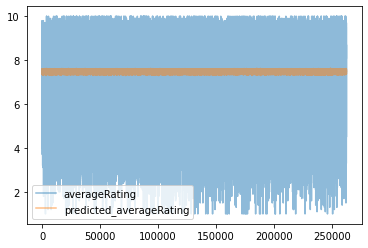

In [ ]:
# show the plot of the regression results
df_popularity[['averageRating', 'predicted_averageRating']].plot(alpha = 0.5);
plt.savefig('/content/drive/MyDrive/regression_popularity_Ratings.png')

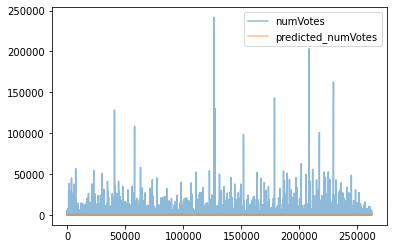

In [ ]:
# show the plot of the regression results
df_popularity[['numVotes','predicted_numVotes']].plot(alpha = 0.5);
plt.savefig('/content/drive/MyDrive/regression_popularity_Votes.png')

In [ ]:
# loading the csv in a dataframe 
df_series = pd.read_csv('/content/drive/MyDrive/series_regression.csv',
                            header = 0, encoding='utf-8')
# randomise the sample order
df_series = df_series.sample(frac = 1).reset_index(drop = True)
display(df_series)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
0,tt5192032,Wingmom,tt2712740,3,9,0,0.289795,-0.702148,2015
1,tt9729588,...White as a Ghost,tt8619822,2,8,0,1.791992,-2.185547,2019
2,tt0532166,Hallie,tt0081837,1,9,0,0.985840,-1.657227,1982
3,tt0811418,The Death & Life of Billy Feral,tt0112091,1,7,1,-1.869141,1.990234,1995
4,tt1111159,In Name and Blood,tt0452046,3,2,0,1.962891,-2.730469,2007
...,...,...,...,...,...,...,...,...,...
262246,tt3687682,Der Traum vom Siljansee,tt0920505,11,5,0,0.631836,-0.799805,2014
262247,tt0505466,The Great Treasure Hunt,tt0057729,2,19,0,1.852539,-2.781250,1966
262248,tt0614751,The Gene Pool,tt0112025,1,3,0,0.982910,-1.706055,1995
262249,tt8905986,My Word is my Bond,tt8905964,1,8,0,1.908203,-2.871094,2019


In [ ]:
# clean the data and arrange it for analysis
df_series = df_series.dropna(subset = None)
# remove the string tt from the series codes if needed
# df_series["seriesCode"] = df_series["seriesCode"].str.replace("tt","")
# remove the trailing spaces
df_series["seasonNumber"] = df_series["seasonNumber"].str.replace(r'\\N', '0',
                                                                  regex = True)
df_series["episodeNumber"] = df_series["episodeNumber"].str.replace(r'\\N', '0',
                                                                    regex= True)
# transform the columns from strings to integers
df_series = df_series.astype({'seasonNumber':'int','episodeNumber':'int'})
# sort the data
df_series = df_series.sort_values(by=['seriesCode', 'seasonNumber',
                                      'episodeNumber'])
display(df_series)

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
60616,tt0622348,Keep Our Honor Bright,tt0039123,7,7,1,-1.260742,1.091797,1953
157763,tt0622201,A Long Time Till Dawn,tt0039123,7,11,0,1.365234,-1.054688,1953
106597,tt0622279,Dog in a Bus Tunnel,tt0039123,11,22,1,-3.275391,2.533203,1958
163113,tt0622660,Three Plays by Tennessee Williams: Moony's Kid...,tt0039123,11,27,1,-1.239258,1.529297,1958
48742,tt0622573,The Man Who Didn't Fly,tt0039123,11,40,0,2.041016,-1.697266,1958
...,...,...,...,...,...,...,...,...,...
128764,tt10197824,"Rikkad lapsed, orvud ja kasulapsed",tt9916380,1,5,1,-2.419922,2.833984,2019
193738,tt10219006,Aafrika jõhkrad traditsioonid,tt9916380,1,7,1,-1.434570,1.673828,2019
10167,tt10197842,Ehitame maja,tt9916380,1,8,0,1.764648,-1.499023,2019
14598,tt10197854,Kanakarja kambakas,tt9916380,1,9,0,0.877441,-0.770508,2019


In [ ]:
# loading the series codes csv file in a dataframe 
df_series_codes = pd.read_csv('/content/drive/MyDrive/series_codes.csv',
                            header = 0, encoding='utf-8')
# sort the data
df_series_codes = df_series_codes.sort_values(by=['seriesCode'])
# create a list with the series codes
series_codes = df_series_codes["seriesCode"].values.tolist()
display(df_series_codes)

,seriesCode
13813,tt0039123
14236,tt0040021
11952,tt0040041
4926,tt0040049
1993,tt0040051
...,...
14559,tt9906902
3237,tt9910728
6186,tt9915144
12367,tt9915338


In [ ]:
stereotypeNumber = [71, [1]]
temp = df_series.loc[(df_series["seriesCode"] == 'tt0040051')]
print(temp['prediction'].sum())
print(temp['prediction'].value_counts())
print(temp['prediction'].value_counts()[0])
stereotypeNumber.append(temp['prediction'].value_counts()[1] + temp['prediction'].value_counts()[0])
stereotypeNumber.append(33)
print(stereotypeNumber)
display(temp["seasonNumber"])

38
1    38
0    33
Name: prediction, dtype: int64
33
[71, [1], 71, 33]


65401      1
146546     1
250239     2
199171     2
149856     2
          ..
102085    10
135582    10
161955    10
199387    10
47228     10
Name: seasonNumber, Length: 71, dtype: int64

In [ ]:
stereotypeNumber = []
episodesNumber = []
seasonNumber = []
for i in series_codes:
  temp = df_series.loc[(df_series["seriesCode"] == i)]
  # stereotypeNumber.append(temp['prediction'].value_counts()[1])
  # episodesNumber.append(len(temp))
  # seasonNumber.append(temp["seasonNumber"].max())
  display(temp, i)

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
60616,tt0622348,Keep Our Honor Bright,tt0039123,7,7,1,-1.260742,1.091797,1953
157763,tt0622201,A Long Time Till Dawn,tt0039123,7,11,0,1.365234,-1.054688,1953
106597,tt0622279,Dog in a Bus Tunnel,tt0039123,11,22,1,-3.275391,2.533203,1958
163113,tt0622660,Three Plays by Tennessee Williams: Moony's Kid...,tt0039123,11,27,1,-1.239258,1.529297,1958
48742,tt0622573,The Man Who Didn't Fly,tt0039123,11,40,0,2.041016,-1.697266,1958


'tt0039123'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
262115,tt0505147,I'm No Hero,tt0040021,1,16,0,1.616211,-1.201172,1949
6119,tt0505144,Hannah,tt0040021,2,15,0,2.128906,-1.581055,1950
192177,tt0505175,The Swan,tt0040021,2,29,0,2.939453,-1.904297,1950


'tt0040021'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
9091,tt0648537,"Carol Channing, Peter Lawford, Maria Riva",tt0040041,6,9,0,1.066406,-1.785156,1953


'tt0040041'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
133604,tt0674383,The Birth of the Movies,tt0040049,3,32,0,2.443359,-1.629883,1951
44560,tt0245266,Marty,tt0040049,5,23,1,-3.316406,2.720703,1953
146314,tt0674465,The Way of an Eagle,tt0040049,5,24,0,2.160156,-1.246094,1953
150226,tt0674357,Run Like a Thief,tt0040049,6,25,0,2.421875,-1.803711,1954
193576,tt0674392,The Death of Billy the Kid,tt0040049,7,23,0,2.216797,-1.500000,1955
215288,tt0674241,A Man Is Ten Feet Tall,tt0040049,8,3,1,-3.474609,2.789062,1955


'tt0040049'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
65401,tt0712469,The Glass Key,tt0040051,1,13,1,-1.087891,1.194336,1949
146546,tt0712271,Flowers from a Stranger,tt0040051,1,15,0,0.159058,-0.173462,1949
250239,tt0712543,The Rival Dummy,tt0040051,2,2,1,-2.625000,2.164062,1949
199171,tt0712560,Two Sharp Knives,tt0040051,2,10,0,1.227539,-0.488525,1949
149856,tt0712334,Mary Poppins,tt0040051,2,15,0,1.996094,-1.134766,1949
...,...,...,...,...,...,...,...,...,...
102085,tt0712179,A Dead Ringer,tt0040051,10,23,0,1.864258,-1.254883,1958
135582,tt0712608,Tongues of Angels,tt0040051,10,24,0,1.360352,-1.048828,1958
161955,tt0712555,The Shadow of a Genius,tt0040051,10,26,0,2.320312,-1.811523,1958
199387,tt0712308,Kurishiki Incident,tt0040051,10,31,0,1.496094,-1.356445,1958


'tt0040051'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
72009,tt0524235,"Rex Newman, Reporter for the Globe and News",tt0041007,5,1,0,2.035156,-1.474609,1953


'tt0041007'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
211730,tt0766168,The Enemy from Within,tt0041014,0,0,0,2.072266,-1.966797,1954


'tt0041014'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
87088,tt1473943,Razor Blades,tt0041015,3,7,0,1.417969,-2.265625,1951
27363,tt1474625,The New Television Set,tt0041015,3,10,0,1.412109,-2.332031,1951
240894,tt1474626,Ralph Threatens to Leave,tt0041015,3,12,0,1.022461,-2.085938,1951
104718,tt1474628,Alice and Ralph Get Dressed for a Date Last Night,tt0041015,3,14,0,1.327148,-2.310547,1951
205630,tt1474629,The Ring Salesman,tt0041015,3,15,0,1.334961,-2.255859,1951


'tt0041015'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
181952,tt0569044,"Buster Keaton, Virginia O'Brien",tt0041021,1,12,0,-0.061554,-0.326172,1949
189900,tt0820220,"Helen Forrest, The Three Stooges",tt0041021,1,25,1,-1.361328,0.896973,1950


'tt0041021'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
98910,tt0581222,"Life, Liberty and Orrin Dooley",tt0041024,1,1,1,-2.923828,2.375000,1952
240218,tt0581176,Birth of a Hero,tt0041024,1,4,1,-1.382812,1.358398,1952
153164,tt0581162,Adventure in Connecticut,tt0041024,1,18,0,1.059570,-0.524414,1953
206295,tt0581231,Marriageable Male,tt0041024,2,22,1,-3.048828,2.705078,1954
59600,tt0581174,Beneath These Waters,tt0041024,2,34,1,-0.253906,0.263428,1954
250257,tt0581256,Segment,tt0041024,3,3,1,0.165771,0.422363,1954
237383,tt0581216,Journey by Moonlight,tt0041024,4,14,1,-0.371338,0.132568,1956
246970,tt0581347,Your Other Love,tt0041024,4,21,1,-2.689453,2.226562,1956
132091,tt0581166,All for a Man,tt0041024,4,23,1,-1.893555,1.687500,1956
36983,tt0581157,A Past Remembered,tt0041024,4,39,0,0.879883,-0.438477,1956


'tt0041024'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
74399,tt1713384,Social Butterfly,tt0041027,0,0,0,1.708008,-1.196289,1955
74940,tt1715129,The Milk Farm,tt0041027,0,0,0,1.140625,-0.985352,1955
88451,tt1715668,Nurse's Aide,tt0041027,0,0,0,1.834961,-1.385742,1956
155149,tt0835158,The Model Parents,tt0041027,0,0,1,-1.381836,0.982910,1949
224564,tt0835157,The Distinguished Guest,tt0041027,1,2,0,2.332031,-1.634766,1949


'tt0041027'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
202820,tt1269893,Borrowed Trouble (1948),tt0041030,1,1,0,2.089844,-1.979492,1952
95675,tt1269444,False Paradise (1948),tt0041030,1,2,0,2.025391,-1.808594,1952
171816,tt1269445,Strange Gamble (1948),tt0041030,1,3,0,1.252930,-1.111328,1952
18890,tt1273025,Unexpected Guest (1947),tt0041030,1,4,0,0.982910,-1.688477,1952
55737,tt1276271,Hoppy's Holiday (1947),tt0041030,1,5,0,1.605469,-2.000000,1952
98417,tt1273023,Fool's Gold (1946),tt0041030,1,8,0,2.003906,-1.923828,1952
153850,tt1273022,Dangerous Venture (1947),tt0041030,1,9,0,1.092773,-1.757812,1952
41677,tt1273024,The Marauders (1947),tt0041030,1,10,0,1.286133,-1.858398,1952
200032,tt1276273,Sinister Journey (1948),tt0041030,1,11,0,1.436523,-1.893555,1952
68039,tt1276272,Silent Conflict (1947),tt0041030,1,12,0,1.838867,-2.164062,1952


'tt0041030'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
181874,tt0771463,Babs and Simon Step Out,tt0041036,1,2,0,2.734375,-1.976562,1949
8356,tt0771465,Egbert's Chemistry Set,tt0041036,1,3,0,2.865234,-2.048828,1949
132970,tt0771466,The French Professor,tt0041036,1,4,0,0.752930,-0.325928,1949
66612,tt1025824,Nervous Breakdown,tt0041036,1,5,0,2.308594,-1.941406,1949
167634,tt1426881,Assistant Manager,tt0041036,1,6,0,2.681641,-2.085938,1949
46764,tt1426890,Riley's Birthday Gift,tt0041036,1,7,0,2.546875,-1.831055,1949
196864,tt1426893,"Riley, Gillis, and Vanderhopper, Inc.",tt0041036,1,8,0,2.550781,-1.769531,1949
171523,tt1426886,Junior Falls for Teacher,tt0041036,1,9,0,2.267578,-1.810547,1949
178087,tt0771464,Junior's Birthday Party,tt0041036,1,12,0,2.662109,-2.023438,1949
9426,tt1426889,Peg's Birthday,tt0041036,1,14,0,2.636719,-1.923828,1950


'tt0041036'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
96895,tt1044471,First Person Singular,tt0041037,1,1,1,-0.808594,0.394775,1946
3346,tt0632306,Just What Happened,tt0041037,3,7,0,1.213867,-1.663086,1950
251032,tt0632379,The Martian Eyes,tt0041037,3,10,0,1.504883,-2.498047,1950
60081,tt0632278,Beware This Woman,tt0041037,3,15,1,-1.086914,1.819336,1950
122550,tt0632304,Jasper,tt0041037,3,18,1,-0.527832,-0.159790,1950
234294,tt0632297,For Release Today,tt0041037,3,22,1,-0.909668,1.359375,1951
183179,tt0632330,Strange Legacy,tt0041037,3,26,0,1.245117,-2.197266,1951
257792,tt0632374,The Mad Dullaghan,tt0041037,3,32,1,-0.819336,1.017578,1951
40947,tt0632357,The Fonceville Curse,tt0041037,3,35,1,-0.512695,0.180420,1951
165645,tt0632300,Grey Reminder,tt0041037,3,36,0,1.455078,-2.439453,1951


'tt0041037'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
134539,tt0635367,Enter the Lone Ranger,tt0041038,1,1,0,2.109375,-2.480469,1949
29701,tt0635480,The Lone Ranger Fights On,tt0041038,1,2,0,2.289062,-2.570312,1949
199834,tt0635481,The Lone Ranger's Triumph,tt0041038,1,3,0,2.371094,-2.679688,1949
178225,tt0635478,The Legion of Old Timers,tt0041038,1,4,0,2.248047,-2.560547,1949
99473,tt0635434,Rustler's Hideout,tt0041038,1,5,0,2.015625,-2.375000,1949
...,...,...,...,...,...,...,...,...,...
10098,tt0635405,Mission for Tonto,tt0041038,5,34,0,2.464844,-2.806641,1957
57652,tt0635394,Journey to San Carlos,tt0041038,5,35,0,2.101562,-2.476562,1957
64990,tt0635457,The Banker's Son,tt0041038,5,36,0,2.281250,-2.570312,1957
215880,tt0635454,The Angel and the Outlaw,tt0041038,5,37,0,2.515625,-2.839844,1957


'tt0041038'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
93060,tt0932000,Fuller's Folly,tt0041040,4,9,0,2.251953,-1.599609,1952
5283,tt0935707,Killer Cat,tt0041040,4,11,0,1.749023,-1.051758,1952
28353,tt0935703,Ferry Boat,tt0041040,4,16,0,1.639648,-1.089844,1953
144342,tt0935718,The Silken Touch,tt0041040,4,18,0,1.962891,-1.419922,1953
135638,tt0640673,Third Rail,tt0041040,4,19,0,0.429443,-0.084167,1953
107772,tt0640663,Death Takes a Partner,tt0041040,4,24,0,1.773438,-1.095703,1953
17721,tt0936925,The Hitch Heisters,tt0041040,4,27,0,2.517578,-1.726562,1953
102051,tt0936923,Room 505,tt0041040,4,32,0,2.691406,-1.958008,1953
169449,tt0640669,The Day Man,tt0041040,4,33,0,2.671875,-1.845703,1953
50113,tt0936922,Hot Fur,tt0041040,4,34,0,2.500000,-1.816406,1953


'tt0041040'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
56951,tt0925507,Altered Will,tt0041042,2,5,0,2.519531,-1.863281,1951
182660,tt0925509,The District Attorney Killer,tt0041042,2,20,0,1.615234,-1.327148,1951
122719,tt0821083,A Jockey Is Murdered,tt0041042,3,3,0,2.388672,-1.747070,1951
119695,tt0821085,Rest Home Murder,tt0041042,3,11,0,2.226562,-1.701172,1951
240511,tt0821082,A Crooner Is Murdered,tt0041042,3,19,1,-3.267578,2.701172,1952
187946,tt0821084,Black Pearls,tt0041042,3,27,0,2.109375,-1.677734,1952
193958,tt1304849,The Comic Strip Killer,tt0041042,4,25,1,-1.299805,1.154297,1953


'tt0041042'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
48211,tt0700841,Papa Romani,tt0041053,1,15,0,0.950195,-0.832031,1950
51749,tt0700825,Closeup,tt0041053,1,35,0,0.769043,-1.480469,1950


'tt0041053'

,titleCodes,originalTitle,seriesCode,seasonNumber,episodeNumber,prediction,NonStereotype,Stereotype,startYear
234635,tt0714121,Goodbye New York,tt0041061,1,0,0,1.506836,-1.418945,1949
60987,tt0713879,A Night at an Inn,tt0041061,1,7,0,2.248047,-2.035156,1949
71292,tt0713911,Dead Ernest,tt0041061,1,8,0,1.509766,-1.384766,1949
217091,tt0714032,The Doors on the Thirteenth Floor,tt0041061,1,12,0,1.628906,-1.442383,1949
42521,tt0714116,The Yellow Scarf,tt0041061,1,13,1,-0.524902,0.522949,1949
...,...,...,...,...,...,...,...,...,...
234430,tt0713991,Portrait of Constance,tt0041061,5,23,0,1.829102,-1.564453,1953
175642,tt0713930,F.O.B. Vienna,tt0041061,5,27,1,-0.234253,0.286865,1953
42903,tt0714013,The Adventure of the Black Baronet,tt0041061,5,31,0,2.144531,-1.864258,1953
154333,tt0714100,The Signal Man,tt0041061,5,35,0,1.340820,-1.080078,1953


'tt0041061'

KeyboardInterrupt: ignored